In [ ]:
import numpy as np

In [ ]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

 Code for Creating Layers

In [ ]:
class Layer:
    def __init__(self, input_size, output_size, activation='relu'):
        """
        Initialize a neural network layer

        Args:
            input_size (int): Number of input features
            output_size (int): Number of neurons in the layer
            activation (str): Activation function to use ('relu' or 'sigmoid')
        """
        self.weights = np.random.randn(input_size, output_size) * 0.01
        self.bias = np.zeros((1, output_size))
        self.activation = activation

    def forward(self, inputs):
        """Forward pass through the layer"""
        self.inputs = inputs
        self.z = np.dot(inputs, self.weights) + self.bias

        if self.activation == 'relu':
            self.output = np.maximum(0, self.z)
        elif self.activation == 'sigmoid':
            self.output = 1 / (1 + np.exp(-self.z))


        return self.output

    def backward(self, output_gradient, learning_rate):
        """Backward pass through the layer"""
        if self.activation == 'relu':
            activation_gradient = np.where(self.z > 0, 1, 0)
        elif self.activation == 'sigmoid':
            activation_gradient = self.output * (1 - self.output)


        activation_gradient *= output_gradient.astype(np.int32)

        # Calculate gradients
        weights_gradient = np.dot(self.inputs.T, activation_gradient)
        input_gradient = np.dot(activation_gradient, self.weights.T)

        # Update parameters
        self.weights -= learning_rate * weights_gradient
        self.bias -= learning_rate * np.sum(activation_gradient, axis=0, keepdims=True)

        return input_gradient

In [ ]:
class FeedForwardNN:
    def __init__(self):
        """Initialize the neural network"""
        self.layers = []

    def add_layer(self, input_size, output_size, activation='relu'):
        """Add a layer to the network"""
        layer = Layer(input_size, output_size, activation)
        self.layers.append(layer)

    def forward(self, X):
        """Forward pass through the entire network"""
        output = X
        for layer in self.layers:
            output = layer.forward(output)
        return output

    def backward(self, loss_gradient, learning_rate):
        """Backward pass through the entire network"""
        gradient = loss_gradient
        for layer in reversed(self.layers):
            gradient = layer.backward(gradient, learning_rate)

    def train(self, X, y, epochs, learning_rate=0.01, batch_size=32):
        """
        Train the neural network

        Args:
            X: Input features
            y: Target values
            epochs: Number of training epochs
            learning_rate: Learning rate for gradient descent
            batch_size: Size of mini-batches
        """
        for epoch in range(epochs):
            total_loss = 0

            # Mini-batch training
            for i in range(0, len(X), batch_size):
                batch_X = X[i:i + batch_size]
                batch_y = y[i:i + batch_size]

                # Forward pass
                predictions = self.forward(batch_X)

                # Calculate loss (MSE)
                loss = np.mean((predictions.astype(np.int32) - batch_y.astype(np.int32)) ** 2)
                total_loss += loss

                # Calculate loss gradient
                loss_gradient = 2 * (predictions.astype(np.int32) - batch_y.astype(np.int32)) / batch_size

                # Backward pass
                self.backward(loss_gradient, learning_rate)

            if epoch % 100 == 0:
                print(f"Epoch {epoch}, Loss: {total_loss/len(X)}")

In [ ]:
# Example usage
if __name__ == "__main__":
    # Generate sample data
    X = np.random.randn(1000, 3)  # 1000 samples, 3 features
    y = np.sum(X, axis=1, keepdims=True) > 0  # Binary classification

    # Create and configure the network
    model = FeedForwardNN()
    model.add_layer(input_size=3, output_size=4, activation='relu')
    model.add_layer(input_size=4, output_size=4, activation='relu')
    model.add_layer(input_size=4, output_size=1, activation='sigmoid')

    # Train the network
    model.train(X, y, epochs=1000, learning_rate=0.01, batch_size=32)

Epoch 0, Loss: 0.01646875
Epoch 100, Loss: 0.01646875
Epoch 200, Loss: 0.01646875
Epoch 300, Loss: 0.01646875
Epoch 400, Loss: 0.01646875
Epoch 500, Loss: 0.01646875
Epoch 600, Loss: 0.01646875
Epoch 700, Loss: 0.01646875
Epoch 800, Loss: 0.01646875
Epoch 900, Loss: 0.01646875


In [ ]:
class MultiClassNN:
    def __init__(self, num_classes):
        self.layers = []
        self.num_classes = num_classes

    def add_layer(self, input_size, output_size, activation='relu'):
        layer = Layer(input_size, output_size, activation)
        self.layers.append(layer)

    def forward(self, X):
        output = X
        for layer in self.layers:
            output = layer.forward(output)
        return output

    def backward(self, loss_gradient, learning_rate):
        gradient = loss_gradient
        for layer in reversed(self.layers):
            gradient = layer.backward(gradient, learning_rate)

    def categorical_cross_entropy(self, predictions, targets):
        epsilon = 1e-15
        predictions = np.clip(predictions, epsilon, 1 - epsilon)
        return -np.sum(targets * np.log(predictions)) / targets.shape[0]

    def train(self, X, y, epochs, learning_rate=0.01, batch_size=32):
        # Convert labels to one-hot encoding
        y_onehot = np.zeros((y.shape[0], self.num_classes))
        y_onehot[np.arange(y.shape[0]), y] = 1

        for epoch in range(epochs):
            total_loss = 0

            for i in range(0, len(X), batch_size):
                batch_X = X[i:i + batch_size]
                batch_y = y_onehot[i:i + batch_size]

                predictions = self.forward(batch_X)
                loss = self.categorical_cross_entropy(predictions, batch_y)
                total_loss += loss

                # Gradient of categorical cross-entropy
                loss_gradient = (predictions - batch_y) / batch_size

                self.backward(loss_gradient, learning_rate)

            if epoch % 100 == 0:
                print(f"Epoch {epoch}, Loss: {total_loss/len(X)}")

    def predict(self, X):
        predictions = self.forward(X)
        return np.argmax(predictions, axis=1)

In [ ]:
# Example usage
if __name__ == "__main__":
    # Generate sample data for 3-class classification
    np.random.seed(42)
    X = np.random.randn(1000, 4)  # 1000 samples, 4 features
    y = np.random.randint(0, 3, 1000)  # 3 classes: 0, 1, 2

    # Create and configure the network
    model = MultiClassNN(num_classes=3)
    model.add_layer(input_size=4, output_size=8, activation='relu')
    model.add_layer(input_size=8, output_size=6, activation='relu')
    model.add_layer(input_size=6, output_size=3, activation='softmax')

    # Train the network
    model.train(X, y, epochs=1000, learning_rate=0.01, batch_size=32)

    # Make predictions
    predictions = model.predict(X[:5])
    print("Predictions for first 5 samples:", predictions)



Epoch 0, Loss: 0.03515559916802968
Epoch 100, Loss: 0.03515559916802968
Epoch 200, Loss: 0.03515559916802968
Epoch 300, Loss: 0.03515559916802968
Epoch 400, Loss: 0.03515559916802968
Epoch 500, Loss: 0.03515559916802968
Epoch 600, Loss: 0.03515559916802968
Epoch 700, Loss: 0.03515559916802968
Epoch 800, Loss: 0.03515559916802968
Epoch 900, Loss: 0.03515559916802968
Predictions for first 5 samples: [1 1 0 0 0]


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Input, Dense
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# Define the model architecture
model1 = models.Sequential()

model1.add(Input(shape=(4,),name="Input Layer"))
model1.add(Dense(8,activation='relu',name="Hidden1"))
model1.add(Dense(6,activation='relu',name="Hidden2"))
model1.add(Dense(3,activation='softmax',name="OutputLayer"))

In [ ]:
# Compile the model
model1.compile(optimizer='sgd',
              loss='sparse_categorical_crossentropy',  # For integer labels
              metrics=['accuracy'])

In [ ]:
# Train the model
model1.fit(X, y, epochs=1000, batch_size=64, validation_split=0.1)

Epoch 1/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.4603 - loss: 1.0293 - val_accuracy: 0.3500 - val_loss: 1.1805
Epoch 2/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.4821 - loss: 1.0155 - val_accuracy: 0.3200 - val_loss: 1.1799
Epoch 3/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.4679 - loss: 1.0316 - val_accuracy: 0.3500 - val_loss: 1.1821
Epoch 4/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.4824 - loss: 1.0168 - val_accuracy: 0.3100 - val_loss: 1.1783
Epoch 5/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.4812 - loss: 1.0209 - val_accuracy: 0.3200 - val_loss: 1.1795
Epoch 6/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.4555 - loss: 1.0249 - val_accuracy: 0.3400 - val_loss: 1.1823
Epoch 7/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.4810 - loss: 1.0110 - val_accuracy: 0.3300 - val_loss: 1.1856
Epoch 8/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.4672 - loss: 1.0201 - val_accu

In [ ]:
from sklearn.datasets import make_blobs,make_moons,make_circles

In [ ]:
data, labels = make_blobs(n_samples=2000, centers=4, n_features=3, random_state=0)
print(data.shape, labels.shape)

(2000, 3) (2000,)


In [ ]:
import matplotlib.colors

In [ ]:
my_cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["red","yellow","green"])

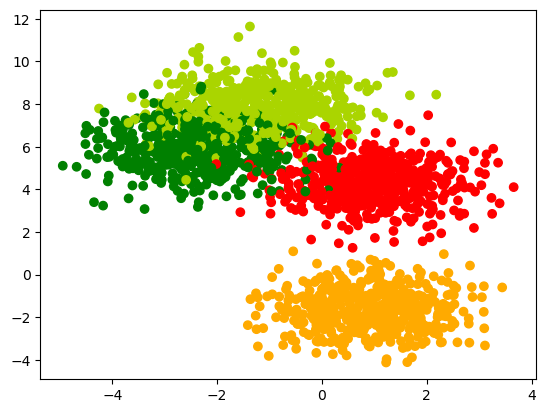

In [ ]:
plt.scatter(data[:,0], data[:,1], c=labels, cmap=my_cmap)
plt.show()

In [ ]:
data, labels = make_moons(n_samples=300, noise=0.2, random_state=42)
print(data.shape, labels.shape)

(300, 2) (300,)


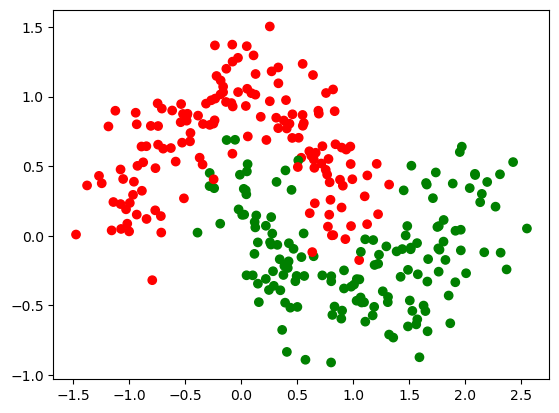

In [ ]:
plt.scatter(data[:,0], data[:,1], c=labels, cmap=my_cmap)
plt.show()

In [ ]:
X, y = make_circles(random_state=42)

In [ ]:
print(X.shape, y.shape)

(100, 2) (100,)


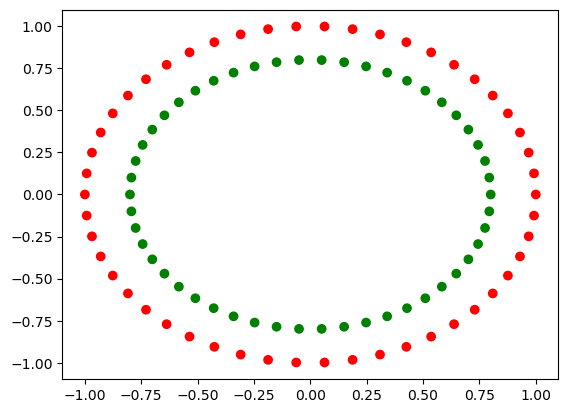

In [ ]:
plt.scatter(X[:,0], X[:,1], c=y, cmap=my_cmap)
plt.show()